# Tarea 2: EfficientDet V2 con Smash Bros dataset
## Óscar Esaú Peralta Rosales 
### Maestría en Ciencias de la Computación - Aprendizaje Máquina II

# Introducción

El año pasado, 2019, Google publicó una nueva [arquitectura de red convolucional](https://arxiv.org/pdf/1905.11946.pdf) (mejor dicho un método de escalado de arquitecturas) que dejó boquiabiertos a todos por el rendimiento que este presenta tomando en cuenta la cantidad de parámetros entrenables que utiliza.

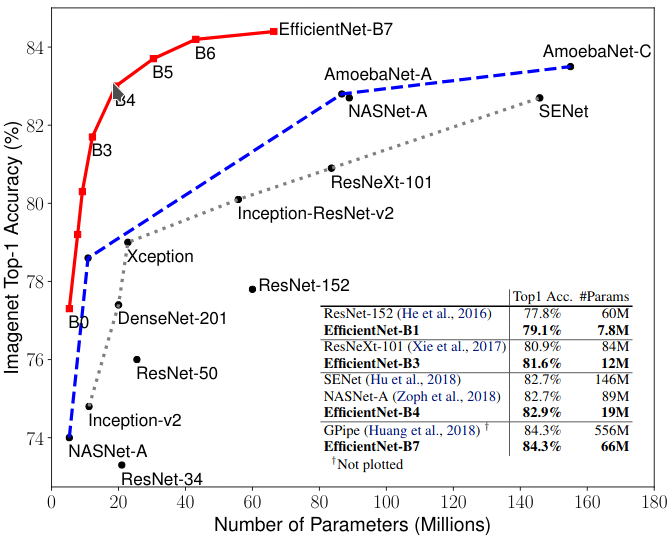

La idea detrás es poder escalar la red en las distintas dimensiones (profundidad, anchura y resolución) de manera eficiente bajo cierto criterio. Ellos mencionan por ejemplo, que si quieres usar $2^N$ veces más recursos computacionales, entonces podemos escalar la red en profundidad por $\alpha^N$, en anchura por $\beta^N$ y en resolución por $\gamma^N$ donde $\alpha$, $\beta$ y $\gamma$ son parámetros a encontrar mediante una pequeña búsqueda en grid sobr el modelo original.

Uno de los problemas al realizar detección de objetos sobre imágenes es que estos pueden presentarse en diferentes escalas. Una de las maneras de lidear con este problema es usando [Feature Pyramid Network (FPN)](https://arxiv.org/pdf/1612.03144.pdf). FPN se compone de dos caminos el *bottom-up* y el *top-down*.

El *bottom-up* es la parte de extracción de características de la red convolucional, asi, mientras más avanzamos en la produnfidad de la red las dimenciones espaciales disminuyen y el información semántica de cada capa incrementa. El *top-down* reconstruye capas de alta resolución a partir de las capas con alto contenido semántico, agregando skip connections para mejorar la presición de la localización de los objetos.

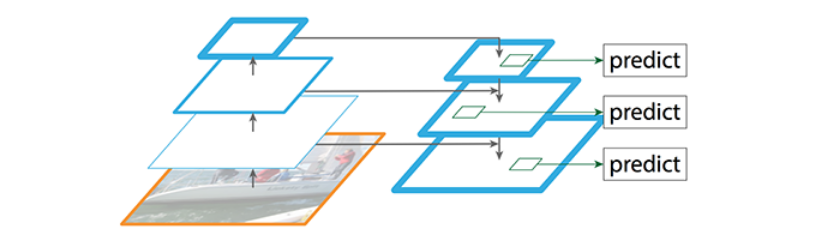

EfficientDet propone una alternativa al modelo FPN a los derivados PANet y NAS_FPE, basado en PANet (que muestra mejores resultados pero con un mayor costo computacional) al eliminar los nodos con una sola conexión de entrada, con el supuesto que estos presentan menos contribución de información y agregando un conexión del inicio al final sobre los nodos del mismo nivel. El crecimiento de esta nueva parte de la red a la que le llaman BiFPN (Bidirectional Feature Piramid Network) no sigue la misma norma de crecimiento de EfficientNet, su profundidad incremente linealmente $D_{bifpn} = 3 + \Phi$ y la anchura por $D_{bifpn} = 64(1.35^{\Phi})$ con $\Phi$ como el número de red que se representa; D0 a D7.

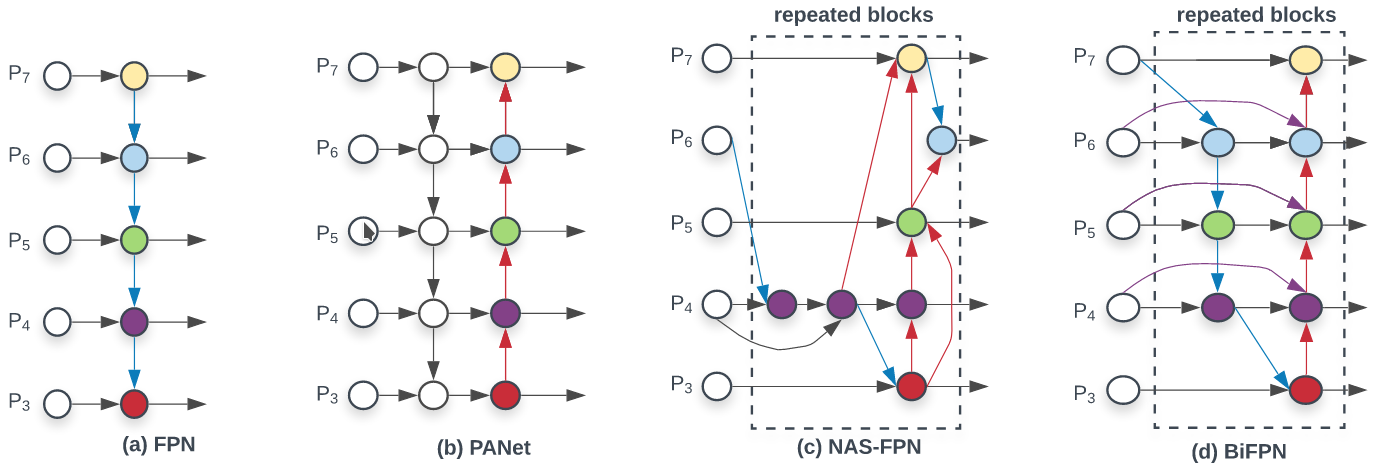

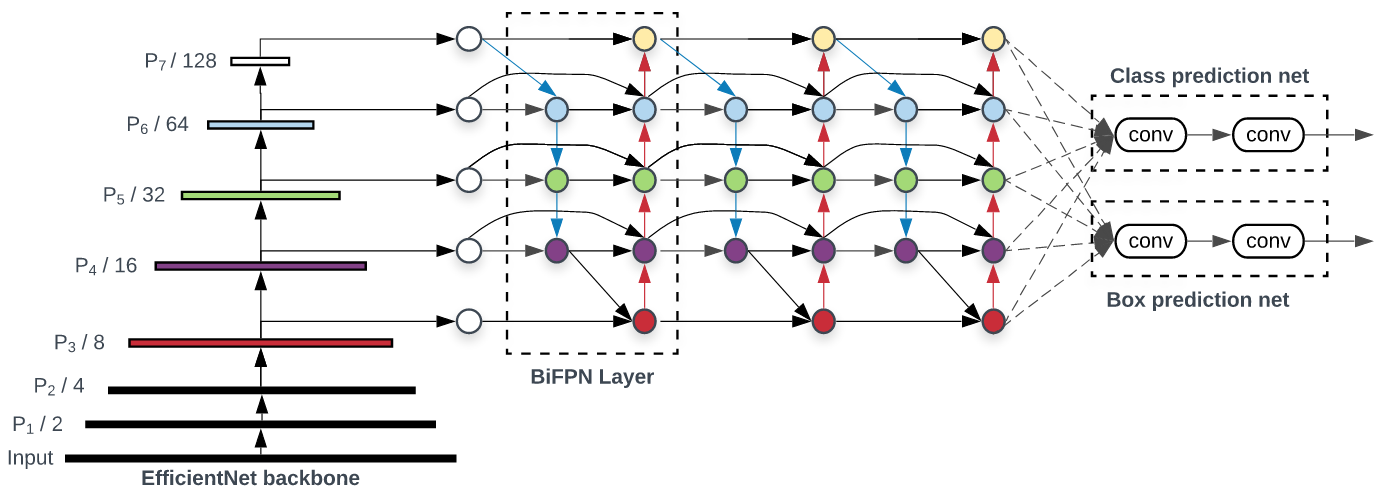

La anchura de la subred de predicción de clases y cajas de los objetos se conservan igual que en la red BiFPN, pero incrementa linealmente por $D_{box} = D_{class} = 3 + \lfloor \Phi / 3 \rfloor$. Y la resolución de la imágen de entrada $R_{input} = 512 + 128\Phi$.

Para más detalles podemos leer el artículo original de [EfficientDet](https://arxiv.org/pdf/1911.09070.pdf).

## Descargando EfficientDet

El proceso de entrenamiento está basado en su gran mayoria en el [tutorial de Roboflow](https://blog.roboflow.com/training-efficientdet-object-detection-model-with-a-custom-dataset/).

Procedemos a descargar el repositorio con la implementacion de EfficientDet en Pytorch e instalamos las dependencias necesarias.


In [ ]:
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git --depth=1

In [ ]:
! cd Monk_Object_Detection/4_efficientdet/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

# Dataset

Smash Bros Ultimate es un videojuego de Nintendo muy popular en estos días. Para generar el dataset se eligió un video desde youtube y se obtuvieron los frames de el. Posteriormente se etiquetaron con ayuda de [LabelIMG](https://github.com/tzutalin/labelImg) y se cargaron en [Roboflow](https://app.roboflow.com) se les aplicó flip y rotation como data augmentation y finalmente se exportaron a formato COCO/Json que es el formato que maneja el modelo de EfficientDet.

En total se etiqueron 400 imágenes con a lo más 8 personajes cada una a la vez y un total de 10 personajes en total.

Desdecargamos los datos desde drive y los colocamos en las carpetas tal cual los meneja el modelo de de EfficientDet

In [62]:
import gdown

In [13]:
g_id = "1kyMfkVDuFLgo93lGqDS_WkTA5x6TxF8R"
gdown.download('https://drive.google.com/uc?id={}'.format(g_id), output='smash_dataset.zip', quiet=False)

!unzip smash_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1kyMfkVDuFLgo93lGqDS_WkTA5x6TxF8R
To: /content/smash_dataset.zip
43.1MB [00:00, 249MB/s]


'smash_dataset.zip'

In [15]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir Smash
!mkdir Smash/annotations
!mkdir Smash/Annotations
!mkdir Smash/Images

In [16]:
%cp train/_annotations.coco.json Smash/annotations/instances_Images.json

In [17]:
%cp train/*.jpg Smash/Images/

# Entrenamiento

Agregamos las bibliotecas de EfficientDet al path the python para poder hacer un import de el y creamos el modelo entrenable.

In [63]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [64]:
from train_detector import Detector

In [66]:
gtf = Detector();

In [68]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Smash";
img_dir = "./";
set_dir = "Images";

In [69]:
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=(512, 512), use_gpu=True)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [70]:
gtf.Model();

Loaded pretrained weights for efficientnet-b0


Para fines prácticos relizamos el entrenamiento con 100 épocas. Los pesos son guardados en la carpeta *trained*

In [71]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [ ]:
%%time
gtf.Train(num_epochs=100, model_output_dir="trained/")

Los pesos del modelo entrenado con el dataset lo puedes obtener [aquí](https://drive.google.com/drive/folders/1-1EDgE-2Fh-hUpB4Gfedl-e4l-Oac8Rv?usp=sharing)

# Resultados

Cargamos nuevamente los pesos en el modelo de inferencia

In [75]:
import random
import json

from IPython.display import Image
from infer_detector import Infer

In [76]:
gtf = Infer();

In [77]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")

Las siguientes son las clases a la que pertenece cada objeto.

In [78]:
#extract class list from our annotations
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = [category['name'] for category in data['categories']]
class_list

['characteres',
 'bulbasaur',
 'charizard',
 'diddi kong',
 'greninja',
 'jigglypuff',
 'lucas',
 'meta knight',
 'roy',
 'squirtle',
 'yoshi']

In [80]:
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]

def pred_rand_img():
    img_path = "test/" + random.choice(test_images);
    duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);
    return Image(filename='output.jpg')

Predecimos los objetos y posiciones de imágenes aleatoreas en el conjunto de prueba.

Done. (0.039s)


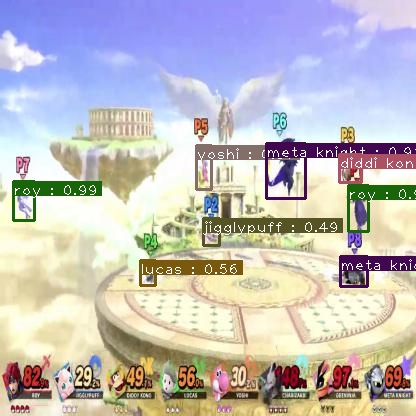

In [48]:
pred_rand_img()

Done. (0.043s)


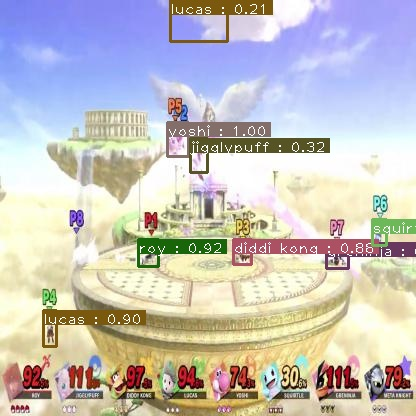

In [50]:
pred_rand_img()

Done. (0.045s)


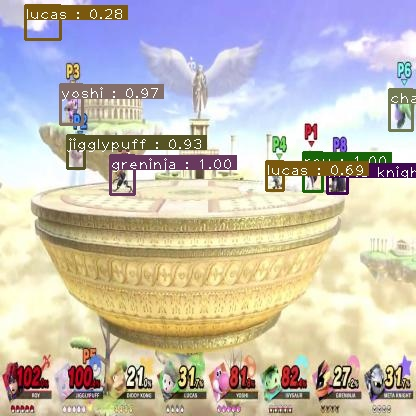

In [51]:
pred_rand_img()

Done. (0.046s)


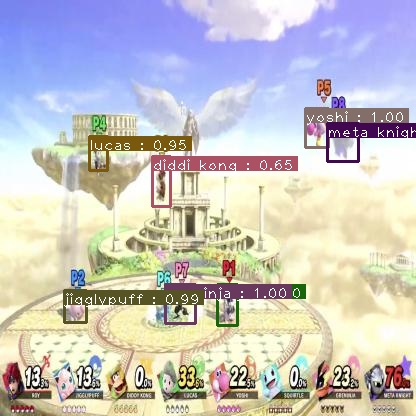

In [52]:
pred_rand_img()

Done. (0.041s)


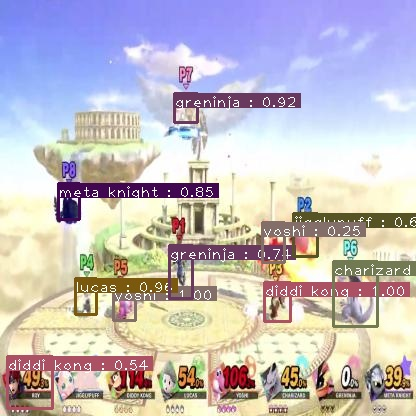

In [55]:
pred_rand_img()

Aún podemos observar algunos errores en la detección. Podría deverse a los siguente:

Muchas de los personajes presentan oclusiones ya sea por los efectos de escena o por otros personajes u objetos de escena. Algo en particular que se observó durante el etiquetado, es que los personajes tienen a tener un efecto de transparencia (blanquedo) cuando estos hacen cierta acción como esquivar o sujetarse en las esquinas de los escenarios haciéndolos muy parecidos al color de las nubes y la red algunas veces tiende a confundir ciertas formas de las nubes con un personaje.

Con mayor número de épocas y más datos de entrenamiento seguramente se obtendrían mejores resultados.